/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default 

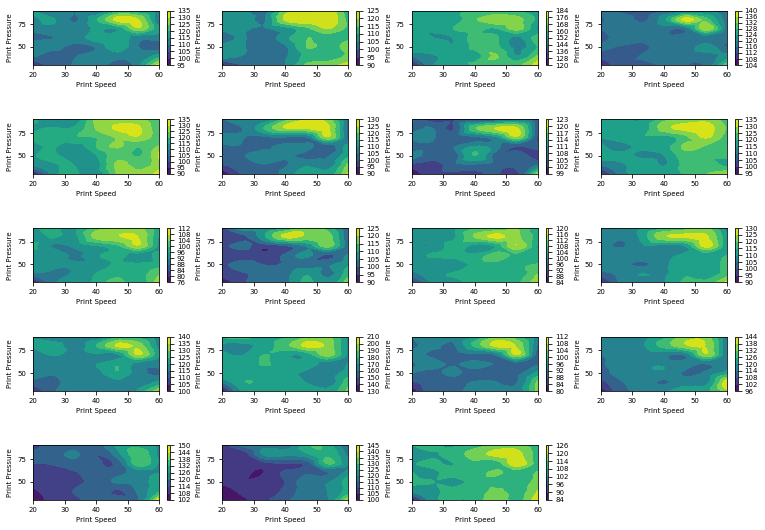

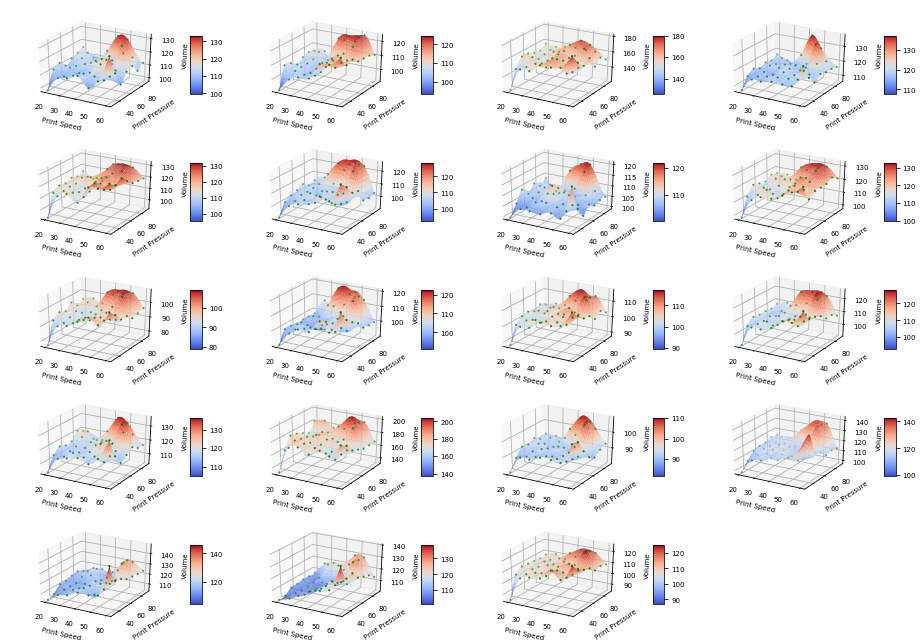

In [0]:
import pandas as pd
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D
import json
from os import listdir
from sklearn.svm import SVR

job_file = 'Job/JOB.json'   # reference
job = pd.read_json(job_file)
list_of_results = listdir("Result")

ps_array = np.zeros((19,1))
pp_array = np.zeros((19,1))
vol_array = np.zeros((19,1))

for filename in list_of_results:
    result_file = 'Result/' + filename
    if result_file[-6] != '1':
        continue

    with open(result_file, 'r') as f:
        data = json.loads(f.read())
        pad_data = data['PADINFO']
        printer_data = data['PRINTERINFO']
        ps = printer_data['Print speed']
        pp = printer_data['Print pressure']
        result = pd.DataFrame.from_dict(pad_data, orient='columns')

    # make validPAD
    Exec = np.array(job['Land']['Exec'])  # list
    X = np.array(job['Land']['X'])[Exec].tolist()
    Y = np.array(job['Land']['Y'])[Exec].tolist()
    SID = np.array(job['Land']['ShapeID'])[Exec].tolist()
    PID = np.array(job['Land']['ID'])[Exec].tolist()

    resultSID = []
    for i in result.PadID:
        j = PID.index(i)
        resultSID.append(SID[j])

    result['ShapeID'] = resultSID

    vol_sid = []
    for sid in set(result.ShapeID):
        vol_sid.append(np.mean(np.array(result.Volume[result.ShapeID == sid])))
    vol_sid = np.transpose([vol_sid])
    vol_array = np.concatenate((vol_array, vol_sid), axis=1)

    ps_array = np.concatenate((ps_array, np.full((19,1), ps)), axis=1)
    pp_array = np.concatenate((pp_array, np.full((19,1), pp)), axis=1)

vol_array = vol_array[:, 1:]
ps_array = ps_array[:, 1:]
pp_array = pp_array[:, 1:]

fig1 = plt.figure(figsize=(13, 9))
fig1.subplots_adjust(hspace=1.0) 
fig = plt.figure(figsize=(13, 9))

for i in range(len(vol_array)):
    z = vol_array[i]
    x = ps_array[i]
    y = pp_array[i]

    xx = np.array([x])
    yy = np.array([y])

    T = np.concatenate((xx.T, yy.T), axis=1)

    regressor = SVR(kernel='rbf')
    regressor.fit(T, z)

    xi = np.linspace(min(x), max(x), 100)
    yi = np.linspace(min(y), max(y), 100)
    X, Y = np.meshgrid(xi, yi)
    ZP = griddata((x, y), z, (xi[None, :], yi[:, None]), method='cubic')

    #part1
    ax1 = fig1.add_subplot(5, 4, i + 1)
    c = ax1.contourf(X, Y, ZP)
    ax1.set_xlabel('Print Speed', fontsize=7)
    ax1.set_ylabel('Print Pressure', fontsize=7)
    for t in ax1.xaxis.get_major_ticks():
        t.label.set_fontsize(7)
    for t in ax1.yaxis.get_major_ticks():
        t.label.set_fontsize(7)
    cbar1 = fig1.colorbar(c)
    cbar1.ax.tick_params(labelsize=7)


    #part2
    ax = fig.add_subplot(5, 4, i + 1, projection='3d')
    surf = ax.plot_surface(X, Y, ZP, antialiased=True, cmap=cm.coolwarm)
    ax.scatter(x, y, z, s=1.5, c='g', marker='o')
    ax.set_zlim(min(z), max(z))
    ax.set_xlabel('Print Speed', fontsize=7)
    ax.set_ylabel('Print Pressure', fontsize=7)
    ax.set_zlabel('Volume', fontsize=7)
    for t in ax.xaxis.get_major_ticks():
        t.label.set_fontsize(7)
    for t in ax.yaxis.get_major_ticks():
        t.label.set_fontsize(7)
    for t in ax.zaxis.get_major_ticks():
        t.label.set_fontsize(7)
    cbar = fig.colorbar(surf, shrink=0.5, aspect=5)
    cbar.ax.tick_params(labelsize=7)
    ax.dist = 12
plt.tight_layout()
plt.show()









